$$
H = \frac{p^2}2 + \gamma \sin(\Theta t) \frac{s^2}2 + D ( 1-e^{-\alpha q})^2
$$

In [1]:
from integrators import contact as ic
from integrators.common import rk4
import scipy.integrate as si

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("fast")  # alt: 'seaborn-white'

# plt.rcParams.update({'font.size': 20, 'font.family': 'serif', 'font.weight':'normal'})
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.bottom"] = True
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.left"] = True
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["mathtext.fontset"] = "cm"

In [3]:
class MOsc:
    def __init__(self, γ, Θ, D=1, α=1, C=0):
        self.γ = γ
        self.D = D
        self.α = α
        self.C = C
        self.Θ = Θ

    def V(self, q, t):
        return self.D * np.square(1.0 - np.exp(-self.α * q)) - self.C

    def Vq(self, q, t):
        return 2 * self.D * self.α * np.exp(-self.α * q) * (1.0 - np.exp(-self.α * q))

    def f(self, t):
        return self.γ * np.sin(self.Θ * t)

    def F(self, z, t):
        return 0.5 * self.f(t) * z ** 2

    def Fz(self, z, t):
        return self.f(t) * z

    def lag(self, p, q, s, t):
        return 0.5 * p ** 2 - self.V(q, t) - self.F(s, t)

    def energy(self, p, q, s, t):
        return 0.5 * p ** 2 + self.F(s, t) + self.V(q, t)

In [4]:
def rk4s(system, init, tspan):
    def derivs(x, t):
        p, q, s = x
        dp = -system.Vq(q, t) - system.f(t) * p * s
        dq = p
        ds = system.lag(p, q, s, t)
        return (dp, dq, ds)

    return rk4(derivs, init, tspan)


def adaptive(system, init, tspan):
    t_span = (tspan[0], tspan[-1])

    def derivs(t, x):
        p, q, s = x
        dp = -system.Vq(q, t) - system.f(t) * p * s
        dq = p
        ds = system.lag(p, q, s, t)
        return (dp, dq, ds)

    return si.solve_ivp(
        derivs, t_span, init, t_eval=tspan, method="LSODA", dense_output=True, rtol=1e-6
    )

## RK4 comparisons

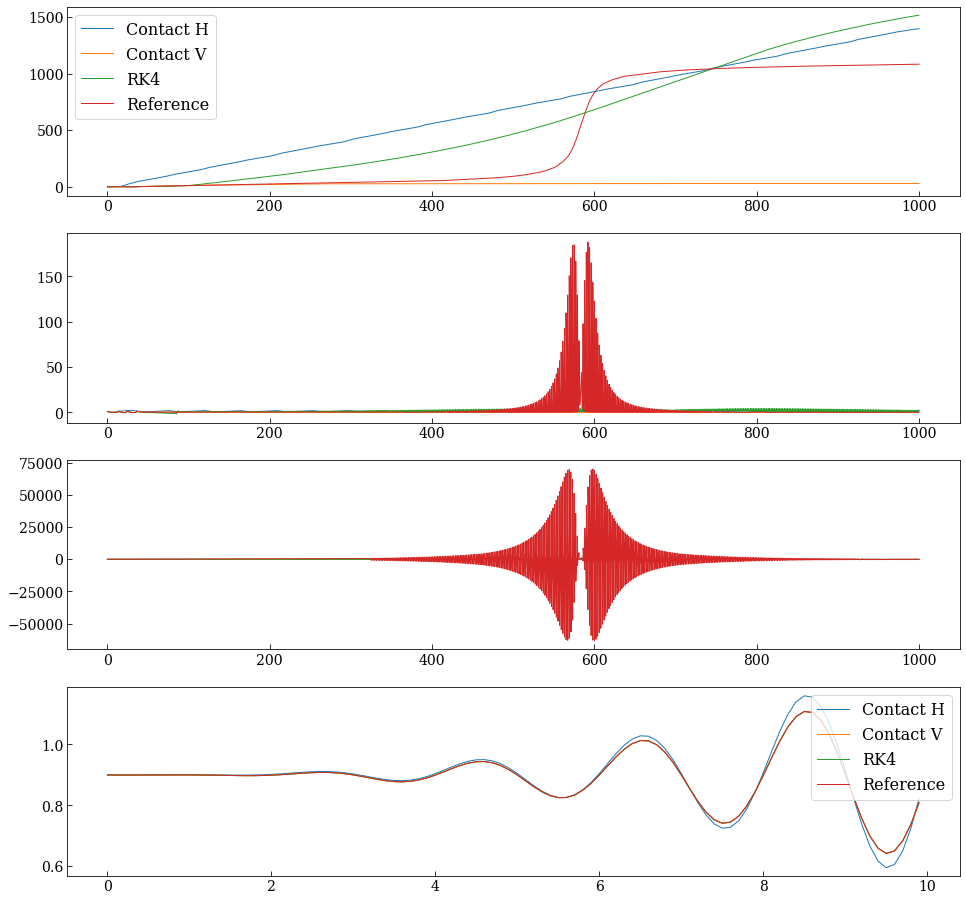

In [5]:
mosc = MOsc(0.01, np.pi)
dt = 0.1
tf = 1000
tspan = np.arange(0.0, tf, dt)

for (p0, q0, s0) in [(1, 1, 0)]:
    fig = plt.figure(figsize=(16, 16))

    solh, solhs, _ = ic.integrate(ic.step1q, mosc, tspan, p0, q0, s0)
    solv, solvs, _ = ic.integrate(ic.variational_step, mosc, tspan, p0, q0, s0)
    solrk = rk4s(mosc, [p0, q0, s0], tspan)
    r = adaptive(mosc, [p0, q0, s0], tspan)
    plt.subplot(411)
    plt.plot(tspan, solh[:, 1], label="Contact H", linewidth=1)
    plt.plot(tspan, solv[:, 1], label="Contact V", linewidth=1)
    plt.plot(tspan, solrk.T[1], label="RK4", linewidth=1)
    plt.plot(tspan, r.y[1], label="Reference", linewidth=1)
    plt.legend()
    plt.subplot(412)
    plt.plot(tspan, solh[:, 0], label="Contact H", linewidth=1)
    plt.plot(tspan, solv[:, 0], label="Contact V", linewidth=1)
    plt.plot(tspan, solrk.T[0], label="RK4", linewidth=1)
    plt.plot(tspan, r.y[0], label="Reference", linewidth=1)
    plt.subplot(413)
    plt.plot(
        tspan,
        mosc.energy(solh[:, 0], solh[:, 1], solhs, tspan),
        label="Contact H",
        linewidth=1,
    )
    plt.plot(
        tspan,
        mosc.energy(solv[:, 0], solv[:, 1], solvs, tspan),
        label="Contact H",
        linewidth=1,
    )
    plt.plot(
        tspan,
        mosc.energy(solrk.T[0], solrk.T[1], solrk.T[2], tspan),
        label="RK4",
        linewidth=1,
    )
    plt.plot(
        tspan,
        mosc.energy(r.y[0], r.y[1], r.y[2], tspan),
        label="Reference",
        linewidth=1,
    )
    plt.subplot(414)
    cut = 100
    plt.plot(
        tspan[:cut],
        mosc.energy(solh[:, 0][:cut], solh[:, 1][:cut], solhs[:cut], tspan[:cut]),
        label="Contact H",
        linewidth=1,
    )
    plt.plot(
        tspan[:cut],
        mosc.energy(solv[:, 0][:cut], solv[:, 1][:cut], solvs[:cut], tspan[:cut]),
        label="Contact V",
        linewidth=1,
    )
    plt.plot(
        tspan[:cut],
        mosc.energy(solrk.T[0][:cut], solrk.T[1][:cut], solrk.T[2][:cut], tspan[:cut]),
        label="RK4",
        linewidth=1,
    )
    plt.plot(
        tspan[:cut],
        mosc.energy(r.y[0][:cut], r.y[1][:cut], r.y[2][:cut], tspan[:cut]),
        label="Reference",
        linewidth=1,
    )
    plt.legend()

    plt.show()

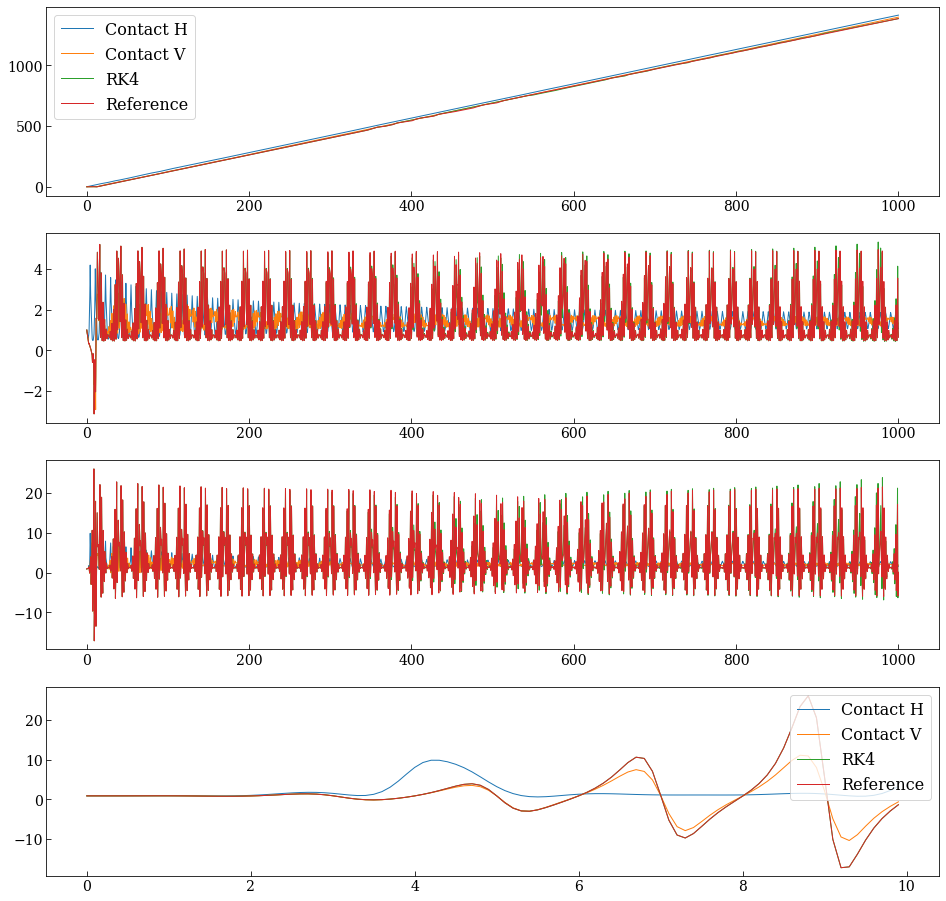

In [6]:
mosc = MOsc(0.5, np.pi)
dt = 0.1
tf = 1000

for (p0, q0, s0) in [(1, 1, 0)]:
    fig = plt.figure(figsize=(16, 16))

    solh, solhs, _ = ic.integrate(ic.step1q, mosc, tspan, p0, q0, s0)
    solv, solvs, _ = ic.integrate(ic.variational_step, mosc, tspan, p0, q0, s0)
    solrk = rk4s(mosc, [p0, q0, s0], tspan)
    r = adaptive(mosc, [p0, q0, s0], tspan)
    plt.subplot(411)
    plt.plot(tspan, solh[:, 1], label="Contact H", linewidth=1)
    plt.plot(tspan, solv[:, 1], label="Contact V", linewidth=1)
    plt.plot(tspan, solrk.T[1], label="RK4", linewidth=1)
    plt.plot(tspan, r.y[1], label="Reference", linewidth=1)
    plt.legend()
    plt.subplot(412)
    plt.plot(tspan, solh[:, 0], label="Contact H", linewidth=1)
    plt.plot(tspan, solv[:, 0], label="Contact V", linewidth=1)
    plt.plot(tspan, solrk.T[0], label="RK4", linewidth=1)
    plt.plot(tspan, r.y[0], label="Reference", linewidth=1)
    plt.subplot(413)
    plt.plot(
        tspan,
        mosc.energy(solh[:, 0], solh[:, 1], solhs, tspan),
        label="Contact H",
        linewidth=1,
    )
    plt.plot(
        tspan,
        mosc.energy(solv[:, 0], solv[:, 1], solvs, tspan),
        label="Contact H",
        linewidth=1,
    )
    plt.plot(
        tspan,
        mosc.energy(solrk.T[0], solrk.T[1], solrk.T[2], tspan),
        label="RK4",
        linewidth=1,
    )
    plt.plot(
        tspan,
        mosc.energy(r.y[0], r.y[1], r.y[2], tspan),
        label="Reference",
        linewidth=1,
    )
    plt.subplot(414)
    cut = 100
    plt.plot(
        tspan[:cut],
        mosc.energy(solh[:, 0][:cut], solh[:, 1][:cut], solhs[:cut], tspan[:cut]),
        label="Contact H",
        linewidth=1,
    )
    plt.plot(
        tspan[:cut],
        mosc.energy(solv[:, 0][:cut], solv[:, 1][:cut], solvs[:cut], tspan[:cut]),
        label="Contact V",
        linewidth=1,
    )
    plt.plot(
        tspan[:cut],
        mosc.energy(solrk.T[0][:cut], solrk.T[1][:cut], solrk.T[2][:cut], tspan[:cut]),
        label="RK4",
        linewidth=1,
    )
    plt.plot(
        tspan[:cut],
        mosc.energy(r.y[0][:cut], r.y[1][:cut], r.y[2][:cut], tspan[:cut]),
        label="Reference",
        linewidth=1,
    )
    plt.legend()

    plt.show()

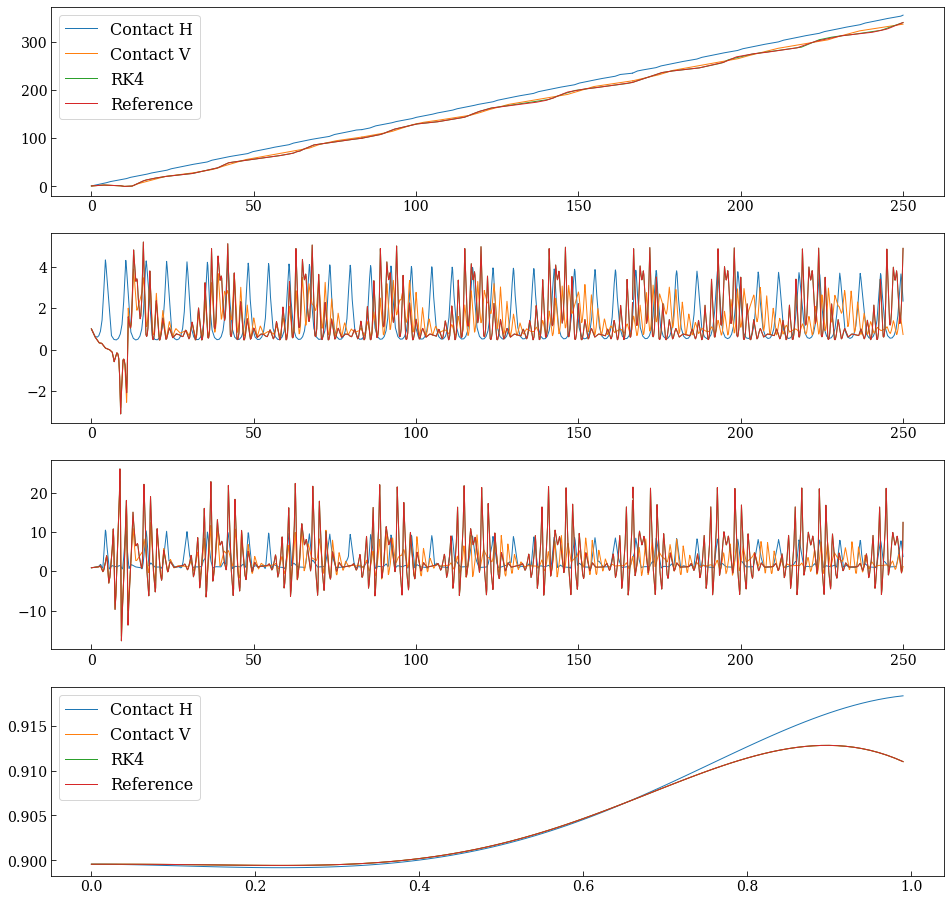

In [9]:
mosc = MOsc(0.5, np.pi)
dt = 0.01
tf = 250
tspan = np.arange(0.0, tf, dt)

for (p0, q0, s0) in [(1, 1, 0)]:
    fig = plt.figure(figsize=(16, 16))

    solh, solhs, _ = ic.integrate(ic.step1q, mosc, tspan, p0, q0, s0)
    solv, solvs, _ = ic.integrate(ic.variational_step, mosc, tspan, p0, q0, s0)
    solrk = rk4s(mosc, [p0, q0, s0], tspan)
    r = adaptive(mosc, [p0, q0, s0], tspan)
    plt.subplot(411)
    plt.plot(tspan, solh[:, 1], label="Contact H", linewidth=1)
    plt.plot(tspan, solv[:, 1], label="Contact V", linewidth=1)
    plt.plot(tspan, solrk.T[1], label="RK4", linewidth=1)
    plt.plot(tspan, r.y[1], label="Reference", linewidth=1)
    plt.legend()
    plt.subplot(412)
    plt.plot(tspan, solh[:, 0], label="Contact H", linewidth=1)
    plt.plot(tspan, solv[:, 0], label="Contact V", linewidth=1)
    plt.plot(tspan, solrk.T[0], label="RK4", linewidth=1)
    plt.plot(tspan, r.y[0], label="Reference", linewidth=1)
    plt.subplot(413)
    plt.plot(
        tspan,
        mosc.energy(solh[:, 0], solh[:, 1], solhs, tspan),
        label="Contact H",
        linewidth=1,
    )
    plt.plot(
        tspan,
        mosc.energy(solv[:, 0], solv[:, 1], solvs, tspan),
        label="Contact H",
        linewidth=1,
    )
    plt.plot(
        tspan,
        mosc.energy(solrk.T[0], solrk.T[1], solrk.T[2], tspan),
        label="RK4",
        linewidth=1,
    )
    plt.plot(
        tspan,
        mosc.energy(r.y[0], r.y[1], r.y[2], tspan),
        label="Reference",
        linewidth=1,
    )
    plt.subplot(414)
    cut = 100
    plt.plot(
        tspan[:cut],
        mosc.energy(solh[:, 0][:cut], solh[:, 1][:cut], solhs[:cut], tspan[:cut]),
        label="Contact H",
        linewidth=1,
    )
    plt.plot(
        tspan[:cut],
        mosc.energy(solv[:, 0][:cut], solv[:, 1][:cut], solvs[:cut], tspan[:cut]),
        label="Contact V",
        linewidth=1,
    )
    plt.plot(
        tspan[:cut],
        mosc.energy(solrk.T[0][:cut], solrk.T[1][:cut], solrk.T[2][:cut], tspan[:cut]),
        label="RK4",
        linewidth=1,
    )
    plt.plot(
        tspan[:cut],
        mosc.energy(r.y[0][:cut], r.y[1][:cut], r.y[2][:cut], tspan[:cut]),
        label="Reference",
        linewidth=1,
    )
    plt.legend()

    plt.show()

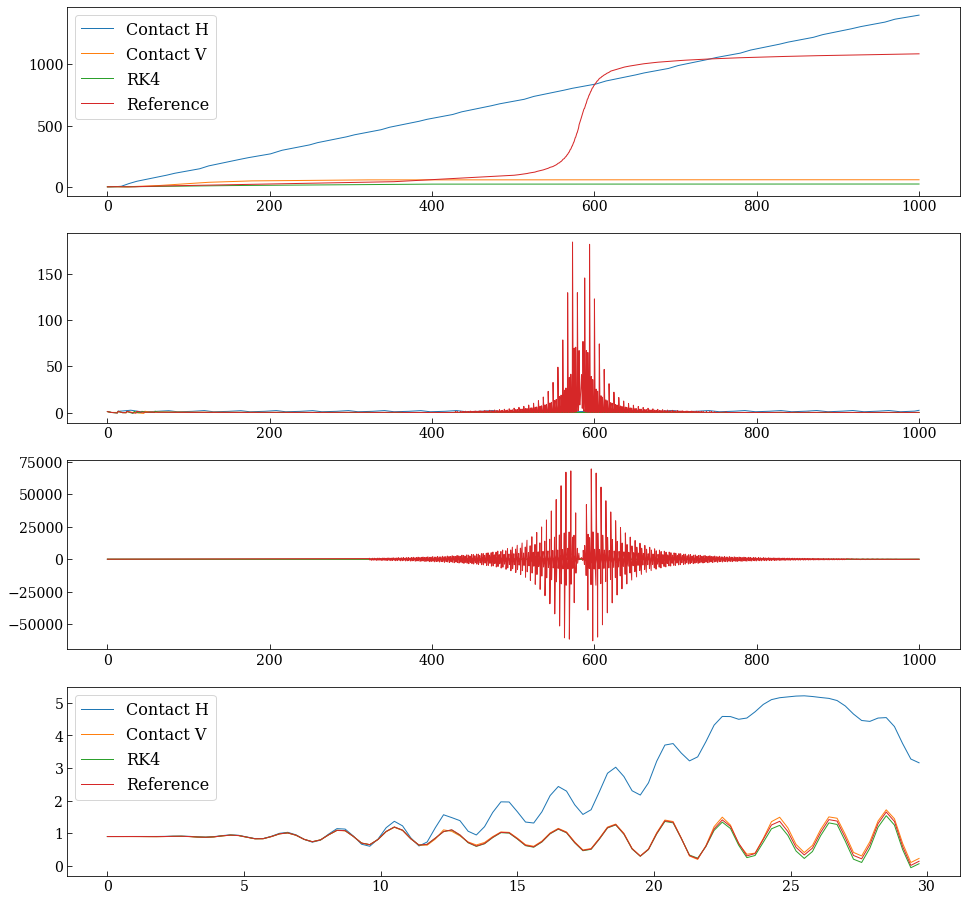

In [10]:
mosc = MOsc(0.01, np.pi)
dt = 0.3
tf = 1000
tspan = np.arange(0.0, tf, dt)

for (p0, q0, s0) in [(1, 1, 0)]:
    fig = plt.figure(figsize=(16, 16))

    solh, solhs, _ = ic.integrate(ic.step1q, mosc, tspan, p0, q0, s0)
    solv, solvs, _ = ic.integrate(ic.variational_step, mosc, tspan, p0, q0, s0)
    solrk = rk4s(mosc, [p0, q0, s0], tspan)
    r = adaptive(mosc, [p0, q0, s0], tspan)
    plt.subplot(411)
    plt.plot(tspan, solh[:, 1], label="Contact H", linewidth=1)
    plt.plot(tspan, solv[:, 1], label="Contact V", linewidth=1)
    plt.plot(tspan, solrk.T[1], label="RK4", linewidth=1)
    plt.plot(tspan, r.y[1], label="Reference", linewidth=1)
    plt.legend()
    plt.subplot(412)
    plt.plot(tspan, solh[:, 0], label="Contact H", linewidth=1)
    plt.plot(tspan, solv[:, 0], label="Contact V", linewidth=1)
    plt.plot(tspan, solrk.T[0], label="RK4", linewidth=1)
    plt.plot(tspan, r.y[0], label="Reference", linewidth=1)
    plt.subplot(413)
    plt.plot(
        tspan,
        mosc.energy(solh[:, 0], solh[:, 1], solhs, tspan),
        label="Contact H",
        linewidth=1,
    )
    plt.plot(
        tspan,
        mosc.energy(solv[:, 0], solv[:, 1], solvs, tspan),
        label="Contact H",
        linewidth=1,
    )
    plt.plot(
        tspan,
        mosc.energy(solrk.T[0], solrk.T[1], solrk.T[2], tspan),
        label="RK4",
        linewidth=1,
    )
    plt.plot(
        tspan,
        mosc.energy(r.y[0], r.y[1], r.y[2], tspan),
        label="Reference",
        linewidth=1,
    )
    plt.subplot(414)
    cut = 100
    plt.plot(
        tspan[:cut],
        mosc.energy(solh[:, 0][:cut], solh[:, 1][:cut], solhs[:cut], tspan[:cut]),
        label="Contact H",
        linewidth=1,
    )
    plt.plot(
        tspan[:cut],
        mosc.energy(solv[:, 0][:cut], solv[:, 1][:cut], solvs[:cut], tspan[:cut]),
        label="Contact V",
        linewidth=1,
    )
    plt.plot(
        tspan[:cut],
        mosc.energy(solrk.T[0][:cut], solrk.T[1][:cut], solrk.T[2][:cut], tspan[:cut]),
        label="RK4",
        linewidth=1,
    )
    plt.plot(
        tspan[:cut],
        mosc.energy(r.y[0][:cut], r.y[1][:cut], r.y[2][:cut], tspan[:cut]),
        label="Reference",
        linewidth=1,
    )
    plt.legend()

    plt.show()